In [3]:
import time, os, sys, pickle, h5py, importlib, gc, copy, re, itertools, timeit, json
os.environ['OMP_NUM_THREADS'] = '8'
os.environ['MKL_NUM_THREADS'] = '8'
os.environ['NUMEXPR_NUM_THREADS'] = '8'
from tqdm.auto import tqdm, trange
from collections import OrderedDict, deque, defaultdict
from pathlib import Path

import torch
import torch.nn.functional as F
import numpy as np, pandas as pd, scipy
from scipy.stats import zscore, ttest_ind, spearmanr, pearsonr
from scipy.sparse import coo_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA, NMF, TruncatedSVD
from sklearn.metrics import silhouette_score, adjusted_rand_score

from umap import UMAP

torch.set_num_threads(16)

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set_style("white")
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
context = dict(device='cuda:0', dtype=torch.float32)

In [5]:
def reload_all():
    import model, load_data, estimate_parameters, estimate_weights, util, initialization, sample_for_integral
    importlib.reload(util)
    importlib.reload(load_data)
    importlib.reload(sample_for_integral)
    importlib.reload(estimate_parameters)
    importlib.reload(estimate_weights)
    importlib.reload(initialization)
    importlib.reload(model)

reload_all()

In [6]:
path2dataset = Path('/work/magroup/tianming/Researches/SpiceMix/version1/data/obsolete/synthetic_500_100_20_15_0_0_i4')
# repli_list = ['0', '1']
repli_list = ['0']

# path2dataset = Path('/work/magroup/tianming/Researches/SpiceMix/version1/data/spatialLIBD_old_spicemix_correct_edges')
# repli_list = ['151507','151508']

In [7]:
df_meta = []
for r in repli_list:
#     df = pd.read_csv(path2dataset / 'files' / f'meta_{r}.csv')
    df = pd.read_csv(path2dataset / 'files' / f'celltypes_{r}.txt', header=None)
    df.columns = ['cell type']
    df['repli'] = r
    df_meta.append(df)
df_meta = pd.concat(df_meta, axis=0).reset_index(drop=True)

In [ ]:
%%time
reload_all()
from model import SpiceMixPlus
from sklearn.cluster import AgglomerativeClustering

def do_umap(obj):
    Xs = [X.cpu().numpy() for X in obj.Xs]

    x = np.concatenate(Xs, axis=0)
    x = StandardScaler().fit_transform(x)
    
    y = AgglomerativeClustering(
        n_clusters=8,
        linkage='ward',
    ).fit_predict(x)
    df_meta['label SpiceMixPlus'] = y
    print(adjusted_rand_score(*df_meta[['cell type', 'label SpiceMixPlus']].values.T))
    plt.figure()
    sns.heatmap(
        df_meta.groupby(['cell type', 'label SpiceMixPlus']).size().unstack().fillna(0).astype(int),
        annot=True, fmt='d',
    )
    plt.show()
    plt.close()
    
    x = UMAP(
        n_neighbors=10,
    ).fit_transform(x)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for ax, key in zip(axes.flat, ['cell type', 'repli']):
        sns.scatterplot(ax=ax, data=df_meta, x=x[:, 0], y=x[:, 1], hue=key, s=5)
    plt.show()
    plt.close()
    
@torch.no_grad()
def load_params(obj, path2result, iiter, load_X=True, load_M=True, load_Sigma_x_inv=True):
    with h5py.File(path2result, 'r') as f:
        if load_X:
            for i, repli in enumerate(obj.repli_list):
                obj.Xs[i][:] = torch.tensor(f[f'latent_states/XT/{repli}/{iiter}'][()], **context)
        if load_M:
            obj.M[:] = torch.tensor(f[f'parameters/M/{iiter}'][()], **context)
        if load_Sigma_x_inv:
            obj.Sigma_x_inv[:] = torch.tensor(f[f'parameters/Sigma_x_inv/{iiter}'][()], **context)

obj = SpiceMixPlus(
    K=10, lambda_SigmaXInv=1e-6,
    repli_list=repli_list,
    context=context,
    context_Y=dict(dtype=torch.float32, device='cpu'),
)
obj.load_dataset(path2dataset)
obj.initialize()
for iiter in trange(1):
    obj.estimate_weights(iiter=iiter, use_spatial=[False]*obj.num_repli)
    obj.estimate_parameters(iiter=iiter, use_spatial=[False]*obj.num_repli)
# do_umap(obj)
obj.initialize_Sigma_x_inv()
Sigma_x_inv_init = obj.Sigma_x_inv.detach().cpu().numpy()
for iiter in range(1, 21):
    obj.estimate_parameters(iiter=iiter, use_spatial=[True]*obj.num_repli)
    obj.estimate_weights(iiter=iiter, use_spatial=[True]*obj.num_repli)
    if iiter % 5 == 0:
        do_umap(obj)

# for debug

In [314]:
%%time
reload_all()
from model import SpiceMixPlus
from sklearn.cluster import AgglomerativeClustering

def do_umap(obj):
    Xs = [X.cpu().numpy() for X in obj.Xs]

    x = np.concatenate(Xs, axis=0)
    x = StandardScaler().fit_transform(x)
    
    y = AgglomerativeClustering(
        n_clusters=8,
        linkage='ward',
    ).fit_predict(x)
    df_meta['label SpiceMixPlus'] = y
    print(adjusted_rand_score(*df_meta[['cell type', 'label SpiceMixPlus']].values.T))
    plt.figure()
    sns.heatmap(
        df_meta.groupby(['cell type', 'label SpiceMixPlus']).size().unstack().fillna(0).astype(int),
        annot=True, fmt='d',
    )
    plt.show()
    plt.close()
    
    x = UMAP(
        n_neighbors=10,
    ).fit_transform(x)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for ax, key in zip(axes.flat, ['cell type', 'repli']):
        sns.scatterplot(ax=ax, data=df_meta, x=x[:, 0], y=x[:, 1], hue=key, s=5)
    plt.show()
    plt.close()
    
@torch.no_grad()
def load_params(obj, path2result, iiter, load_X=True, load_M=True, load_Sigma_x_inv=True):
    with h5py.File(path2result, 'r') as f:
        if load_X:
            for i, repli in enumerate(obj.repli_list):
                obj.Xs[i][:] = torch.tensor(f[f'latent_states/XT/{repli}/{iiter}'][()], **context)
        if load_M:
            obj.M[:] = torch.tensor(f[f'parameters/M/{iiter}'][()], **context)
        if load_Sigma_x_inv:
            obj.Sigma_x_inv[:] = torch.tensor(f[f'parameters/Sigma_x_inv/{iiter}'][()], **context)

obj = SpiceMixPlus(
    K=10, lambda_SigmaXInv=1e-6,
    repli_list=repli_list,
    context=context,
    context_Y=dict(dtype=torch.float32, device='cpu'),
)
obj.load_dataset(path2dataset)
obj.initialize()
for iiter in trange(1):
    obj.estimate_weights(iiter=iiter, use_spatial=[False]*obj.num_repli)
    obj.estimate_parameters(iiter=iiter, use_spatial=[False]*obj.num_repli)
# do_umap(obj)
obj.initialize_Sigma_x_inv()
path2result = Path(
    '/work/magroup/tianming/Researches/SpiceMix/version1/data/obsolete/'
    'synthetic_500_100_20_15_0_0_i4/results/SpiceMix_nFOVs1_K10_rs4_1e-4_lx1.h5'
)
load_params(obj, path2result, 10, load_Sigma_x_inv=False)
# load_params(obj, path2result, 0, load_Sigma_x_inv=True)
obj.initialize_Sigma_x_inv()
Sigma_x_inv_init = obj.Sigma_x_inv.detach().cpu().numpy()
# load_params(obj, path2result, 100, load_X=False, load_M=False)
load_params(obj, path2result, 10, load_X=False, load_M=False)
Sigma_x_inv_old = obj.Sigma_x_inv.detach().cpu().numpy()
obj.estimate_parameters(iiter=0, use_spatial=[True]*obj.num_repli)
Sigma_x_inv = obj.Sigma_x_inv.detach().cpu().numpy()
# do_umap(obj)
# for iiter in range(1, 21):
#     obj.estimate_parameters(iiter=iiter, use_spatial=[True]*obj.num_repli)
#     obj.estimate_weights(iiter=iiter, use_spatial=[True]*obj.num_repli)
#     if iiter % 5 == 0:
#         do_umap(obj)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

-0.04057316482067108
CPU times: user 3min 12s, sys: 3.69 s, total: 3min 15s
Wall time: 3min 9s


In [311]:
# %debug

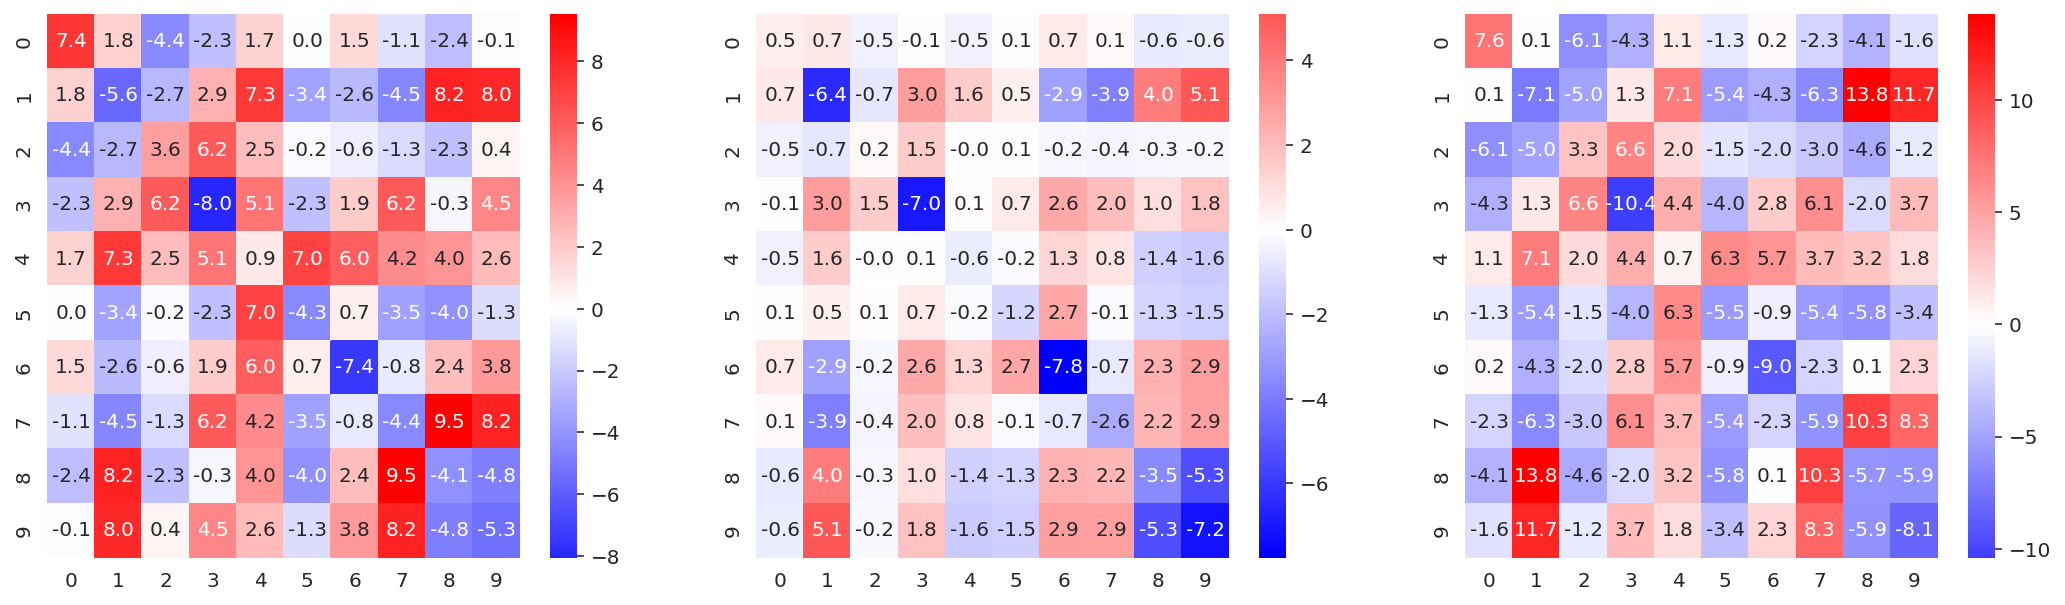

In [315]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
kwargs = dict(
    annot=True,
    fmt='.1f',
    cmap='bwr',
    center=0,
)
for ax, x in zip(axes.flat, [Sigma_x_inv_old, Sigma_x_inv_init, Sigma_x_inv]):
    sns.heatmap(x, ax=ax, **kwargs)

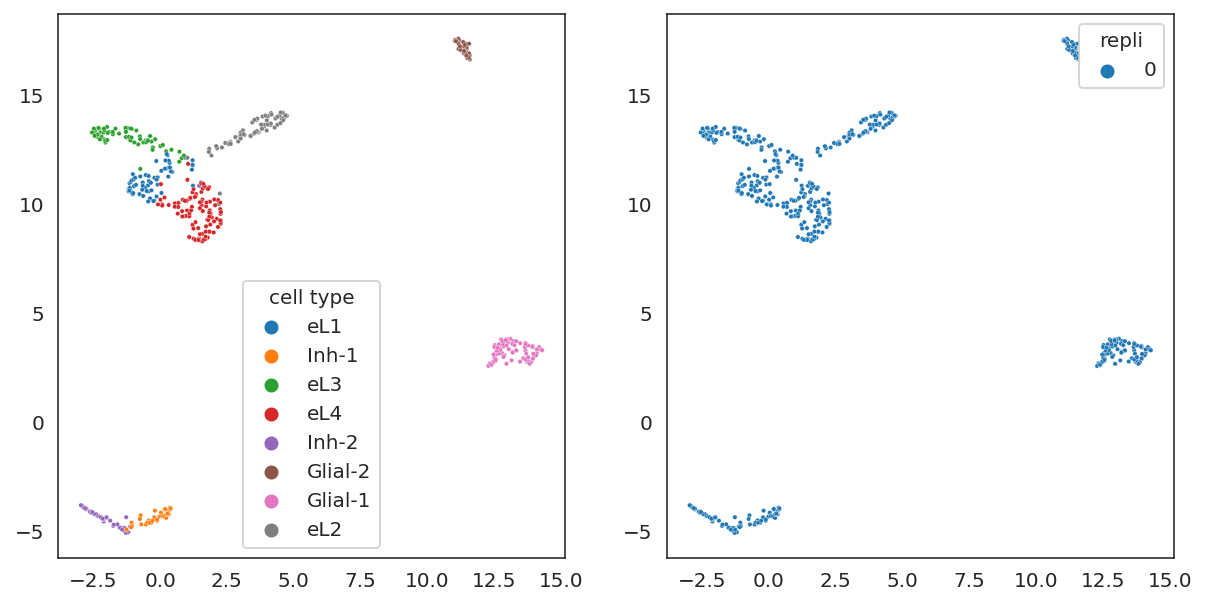

In [218]:
Xs = [X.cpu().numpy() for X in obj.Xs]

x = np.concatenate(Xs, axis=0)
x = StandardScaler().fit_transform(x)
x = UMAP(
    n_neighbors=20,
).fit_transform(x)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for ax, key in zip(axes.flat, ['cell type', 'repli']):
    sns.scatterplot(ax=ax, data=df_meta, x=x[:, 0], y=x[:, 1], hue=key, s=5)

0.7145503473988423

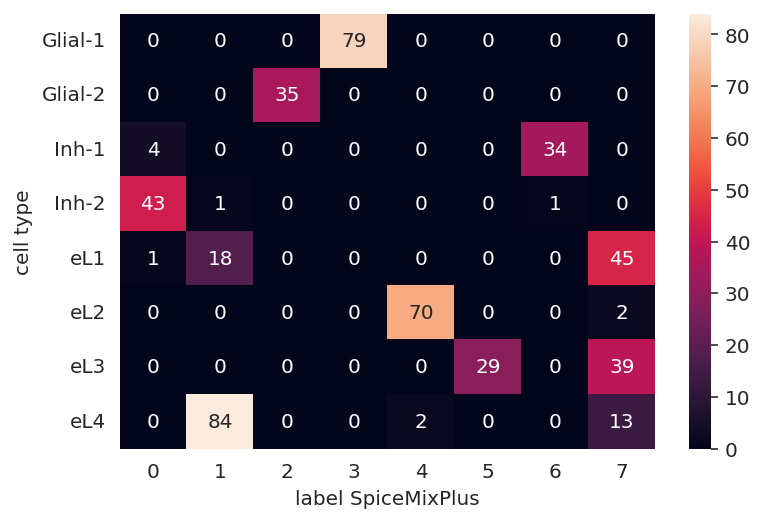

In [212]:
from sklearn.cluster import AgglomerativeClustering
def clustering(Xs):
    X = np.concatenate(Xs, axis=0)
    X = StandardScaler().fit_transform(X)
    y = AgglomerativeClustering(
        n_clusters=8,
        linkage='ward',
    ).fit_predict(X)
    return y
df_meta['label SpiceMixPlus'] = clustering(Xs)
sns.heatmap(df_meta.groupby(['cell type', 'label SpiceMixPlus']).size().unstack().fillna(0).astype(int), annot=True, fmt='d')
adjusted_rand_score(*df_meta[['cell type', 'label SpiceMixPlus']].values.T)

0.5516099501860006